**Author:** Matt Sarmiento

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datasets" data-toc-modified-id="Datasets-1">Datasets</a></span></li><li><span><a href="#Data-Clean" data-toc-modified-id="Data-Clean-2">Data Clean</a></span><ul class="toc-item"><li><span><a href="#Synthetic-Opioids-1999-2017" data-toc-modified-id="Synthetic-Opioids-1999-2017-2.1">Synthetic Opioids 1999-2017</a></span></li><li><span><a href="#All-Drugs-1979-1989" data-toc-modified-id="All-Drugs-1979-1989-2.2">All Drugs 1979-1989</a></span></li><li><span><a href="#All-Drugs-1999-2017" data-toc-modified-id="All-Drugs-1999-2017-2.3">All Drugs 1999-2017</a></span></li><li><span><a href="#Provisional-Counts-2018" data-toc-modified-id="Provisional-Counts-2018-2.4">Provisional Counts 2018</a></span></li><li><span><a href="#Concat" data-toc-modified-id="Concat-2.5">Concat</a></span></li><li><span><a href="#Split" data-toc-modified-id="Split-2.6">Split</a></span></li></ul></li><li><span><a href="#Fentanyl-Rise-Plot" data-toc-modified-id="Fentanyl-Rise-Plot-3">Fentanyl Rise Plot</a></span></li></ul></div>

In [19]:
# Third-party libs
import pandas as pd

# Local modules
import mydata

In [20]:
# Load rpy2 extension (may need to re-run)
%reload_ext rpy2.ipython

In [21]:
# Load R libraries
%R library(ggplot2, scales)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

----------------------

# Datasets

We're dealing with the following datasets:
1. Deaths per year due to all drugs, 1979-1989
2. Deaths per year due to all drugs, 1999-2017
3. Deaths per year due to synthetic opioids, 1999-2017
4. Provisional deaths per year per drug type, 2015 - Feb. 2019

**Note:** Provisional deaths are counted on a rolling 12-month basis, e.g. counts for December 2018 are for the period Jan. - Dec. 2018.

**Important:** The provisional dataset contains
* Confirmed death counts
* Predicted death counts

We'll use the predicted death counts for our 2018 figures. Our reasoning is:
* The data is provisional in any case, so no harm is done in using unconfirmed counts
* The unconfirmed counts are virtually guaranteed to be undercounts. Also, there is some sound statistics behind the provisional counts. Visit https://www.cdc.gov/nchs/nvss/vsrr/drug-overdose-data.htm for more on how predictions are made

--------------------------------

# Data Clean

## Synthetic Opioids 1999-2017


In [22]:
# Deaths due to synthetic opioids per year
synthetic = pd.read_csv('../input/synthetic-deaths-1999-2017.csv', sep='\t')
synthetic.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1999.0,1999.0,730.0,279040168.0,0.3,0.3


## All Drugs 1979-1989

In [23]:
# Load data
drugs_pre1990 = pd.read_csv('../input/deaths-1979-1998.csv', sep='\t')
drugs_pre1990.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1979.0,1979.0,6459.0,224635398.0,2.9,3.0


## All Drugs 1999-2017

In [24]:
# Deaths from all drugs per year
drugs = pd.read_csv('../input/deaths-1999-2017.csv', sep='\t')
drugs.head(1)

,Notes,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1999.0,1999.0,16849.0,279040168.0,6.0,6.1


## Provisional Counts 2018

In [25]:
# Load data
types_prov = pd.read_csv('../input/provisional-deaths-per-type-2019.csv')
types_prov.head(1)

,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Footnote,Footnote Symbol,Predicted Value
0,AK,2015,April,12 month-ending,Natural & semi-synthetic opioids (T40.2),NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN


In [26]:
# Gets 2018 data for entire U.S.
types2018 = (types_prov.loc[(types_prov.State == "US") & 
                            (types_prov.Year == 2018)  &
                            (types_prov.Month == "December")])

# Selects cols we want
# (Recall: we're using predicted counts)
types2018 = types2018[["State", "Year", "Indicator", "Predicted Value"]]

# Re-names col so we can concatenate on it later
types2018 = types2018.rename(columns={"Predicted Value": "Deaths"})

# Converts series' entries to floats (e.g. 1,532 --> 1532)
types2018["Deaths"] = mydata.series2float(types2018["Deaths"])

In [27]:
# Overdoses for synthetic opioids for entire U.S.
synth2018 = types2018.loc[types2018.Indicator.str.startswith("Synthetic")]

# Overdoses for all drugs for entire U.S.
all2018 = types2018.loc[types2018.Indicator == "Number of Drug Overdose Deaths"]

In [28]:
all2018

,State,Year,Indicator,Deaths
18759,US,2018,Number of Drug Overdose Deaths,68618.0


## Concat

We need to concatenate the following datasets:
* All drugs, 1979-1989
* All drugs, 1990-2017
* All drugs, 2018

as well as:
* Synthetic drugs, 1990-2017
* Synthetic drugs, 2018

In [29]:
# Concatenate frames
synth_all = pd.concat([synthetic, synth2018], sort=True, ignore_index=True)
drugs_all = pd.concat([drugs_pre1990, drugs, all2018], sort=True, ignore_index=True)

In [30]:
# Filters out rows with Year = Nan
# (these are rows with comments at the bottom of the csv file)
synth_all = synth_all.loc[synth_all.Year.isna() == False]
drugs_all = drugs_all.loc[drugs_all.Year.isna() == False]

In [31]:
# Selects cols we want & resets index
synth_all = synth_all[["Year", "Deaths"]].reset_index(drop=True)
drugs_all = drugs_all[["Year", "Deaths"]].reset_index(drop=True)

In [32]:
drugs_all.head(3)

,Year,Deaths
0,1979.0,6459.0
1,1980.0,6094.0
2,1981.0,6227.0


## Split

We need to split our data frames as follows:
* All drugs, 1980-2014 (pre-fentanyl spike)
* All drugs, 2014-2017 (post-fentanyl spike)
* All drugs, 2017-2018 (provisional)


* Synthetic opioids, 1999-2014 (pre-fentanyl spike)
* Synthetic opioids, 2014-2017 (post-fentanyl spike)
* Synthetic opioids, 2017-2018 (provisional)

In [33]:
# Splits at jump in fentanyl overdoses (2014-15)
# (for colour-coding in ggplot)
synth_pre2014 = synth_all[:15]
synth_post2014 = synth_all[14:-1]

drugs_pre2014 = drugs_all[1:35]
drugs_post2014 = drugs_all[34:-1]

drugs_post2014

,Year,Deaths
34,2013.0,43982.0
35,2014.0,47055.0
36,2015.0,52404.0
37,2016.0,63632.0
38,2017.0,70237.0


In [34]:
# Splits off provisional 2018 data
synth2018 = synth_all[-2:]
all2018 = drugs_all[-2:]

all2018

,Year,Deaths
38,2017.0,70237.0
39,2018.0,68618.0


---------------------

# Fentanyl Rise Plot

TODO:
* Consider adding "Source" to the caption


In [35]:
# Push data to R
%R -i synth_pre2014
%R -i synth_post2014

%R -i drugs_pre2014
%R -i drugs_post2014

%R -i synth2018
%R -i all2018

In [36]:
%%R

# Custom Theme
theme_custom <- theme(panel.grid = element_blank(),
                      axis.ticks.length = unit(0.20, "cm"),
                      axis.ticks.x = element_line(colour = "grey40", size = 0.5),
                      axis.text.x = element_text(size = 13, colour = "grey50", vjust = 0),
                      axis.text.y = element_blank(),
                      axis.title = element_blank(),
                      plot.title = element_text(size = 29.5, colour = "grey20", vjust = 0),
                      plot.subtitle = element_text(size = 21.5, colour = "grey40", vjust = -2),
                      plot.caption = element_text(size = 12, colour = "grey60", vjust = 3),
                      plot.margin = unit(c(0.5, 0.5, 1, 0.5), "cm"))

# Colours
highlight = "violetred2"

# Sizes
lwidth = 1.1
med = 7
small = 4.8

# Positions for margin notes
x1 <- 2018.7

# Axes marks
xbreaks <- c(1980, 1990, 2000, 2010, 2013)
xlabs <- c(1980, 1990, 2000, 2010, "'13")

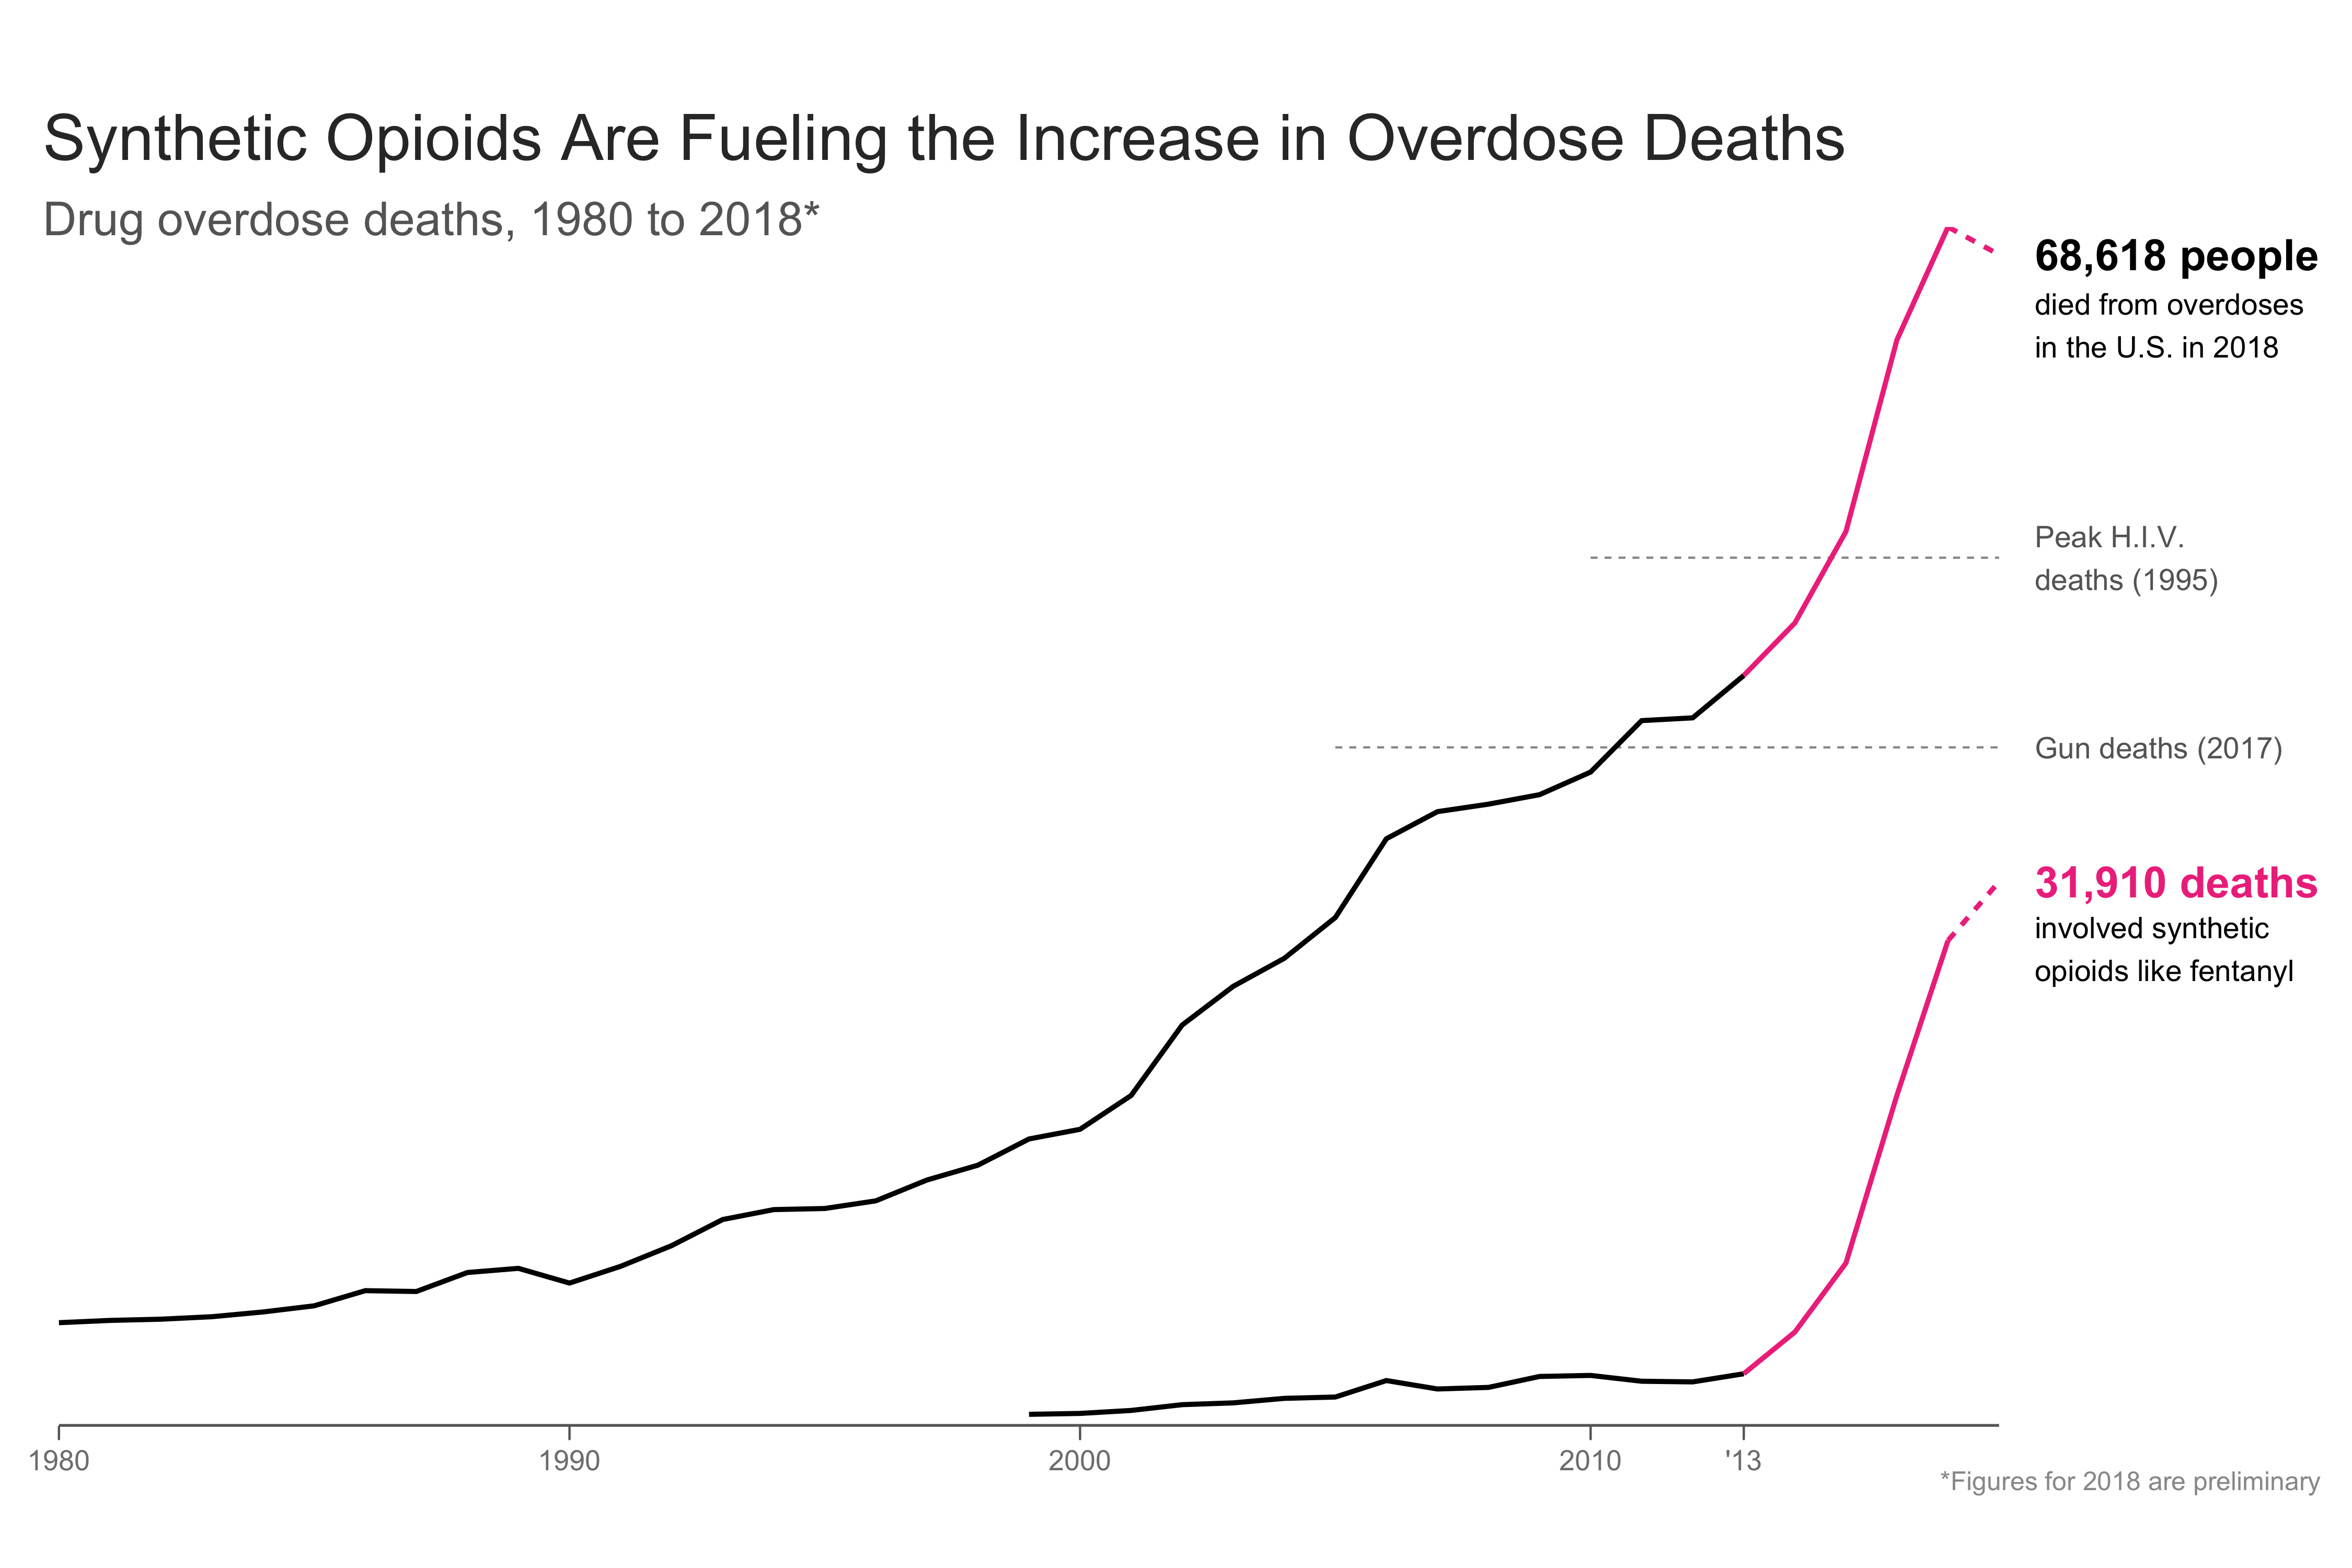

In [37]:
%%R -h 10 -w 15 -u in -r 300


# Base
q <- ggplot()


##################################################
# Geoms
##################################################


# AIDS horizontal ref
q <- q + geom_segment(aes(x = 2010, y = 50877, xend = 2018, yend = 50877), linetype = "33", colour = "grey60")
q <- q + annotate("text", label = "Peak H.I.V.\ndeaths (1995)", x = x1, y = 50877, colour = "grey40", 
                  size = small, hjust = 0)

# 2017 Gun deaths horizontal ref
q <- q + geom_segment(aes(x = 2005, y = 39773, xend = 2018, yend = 39773), linetype = "33", colour = "grey60")
q <- q + annotate("text", label = "Gun deaths (2017)", x = x1, y = 39773, colour = "grey40", size = small,
                  hjust = 0)

# 1999-2014 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = drugs_pre2014, size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synth_pre2014, size = lwidth)

# 2014-2017 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = drugs_post2014, colour = highlight, size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synth_post2014, colour = highlight, size = lwidth)

# Provisional 2018 data
q <- q + geom_line(aes(x = Year, y = Deaths), data = all2018, colour = highlight, linetype = "22", size = lwidth)
q <- q + geom_line(aes(x = Year, y = Deaths), data = synth2018, colour = highlight, linetype = "22", size = lwidth)


##################################################
# Annnotations
##################################################


# Total deaths annotation
q <- q + annotate("text", label = "68,618 people", x = x1, y = 68618, fontface = "bold", size = med, hjust = 0)
q <- q + annotate("text", label = "died from overdoses\nin the U.S. in 2018", x = x1, y = 64500, 
                  size = small, hjust = 0)

# Synthetic deaths annotation
q <- q + annotate("text", label = "31,910 deaths", x = x1, y = 31910, hjust = 0, fontface = "bold", size = med,
                  colour = highlight)
q <- q + annotate("text", label = "involved synthetic\nopioids like fentanyl", x = x1, y = 28000, size = small, hjust = 0)


# Titles
q <- q + labs(title = "\nSynthetic Opioids Are Fueling the Increase in Overdose Deaths")
q <- q + labs(subtitle = "Drug overdose deaths, 1980 to 2018*")
q <- q + labs(caption = "*Figures for 2018 are preliminary")


# Axes
q <- q + geom_segment(aes(x = 1980, y = 0, xend = 2018, yend = 0), colour = "grey40", size = 1.2)
q <- q + scale_x_continuous(breaks = xbreaks, labels = xlabs, expand = c(0.007,0))
q <- q + scale_y_continuous(expand = c(0,0))
q <- q + coord_cartesian(xlim = c(1980, 2024))


# Themes
q <- q + theme_minimal() + theme_custom

q

R[write to console]: Saving 15 x 10 in image



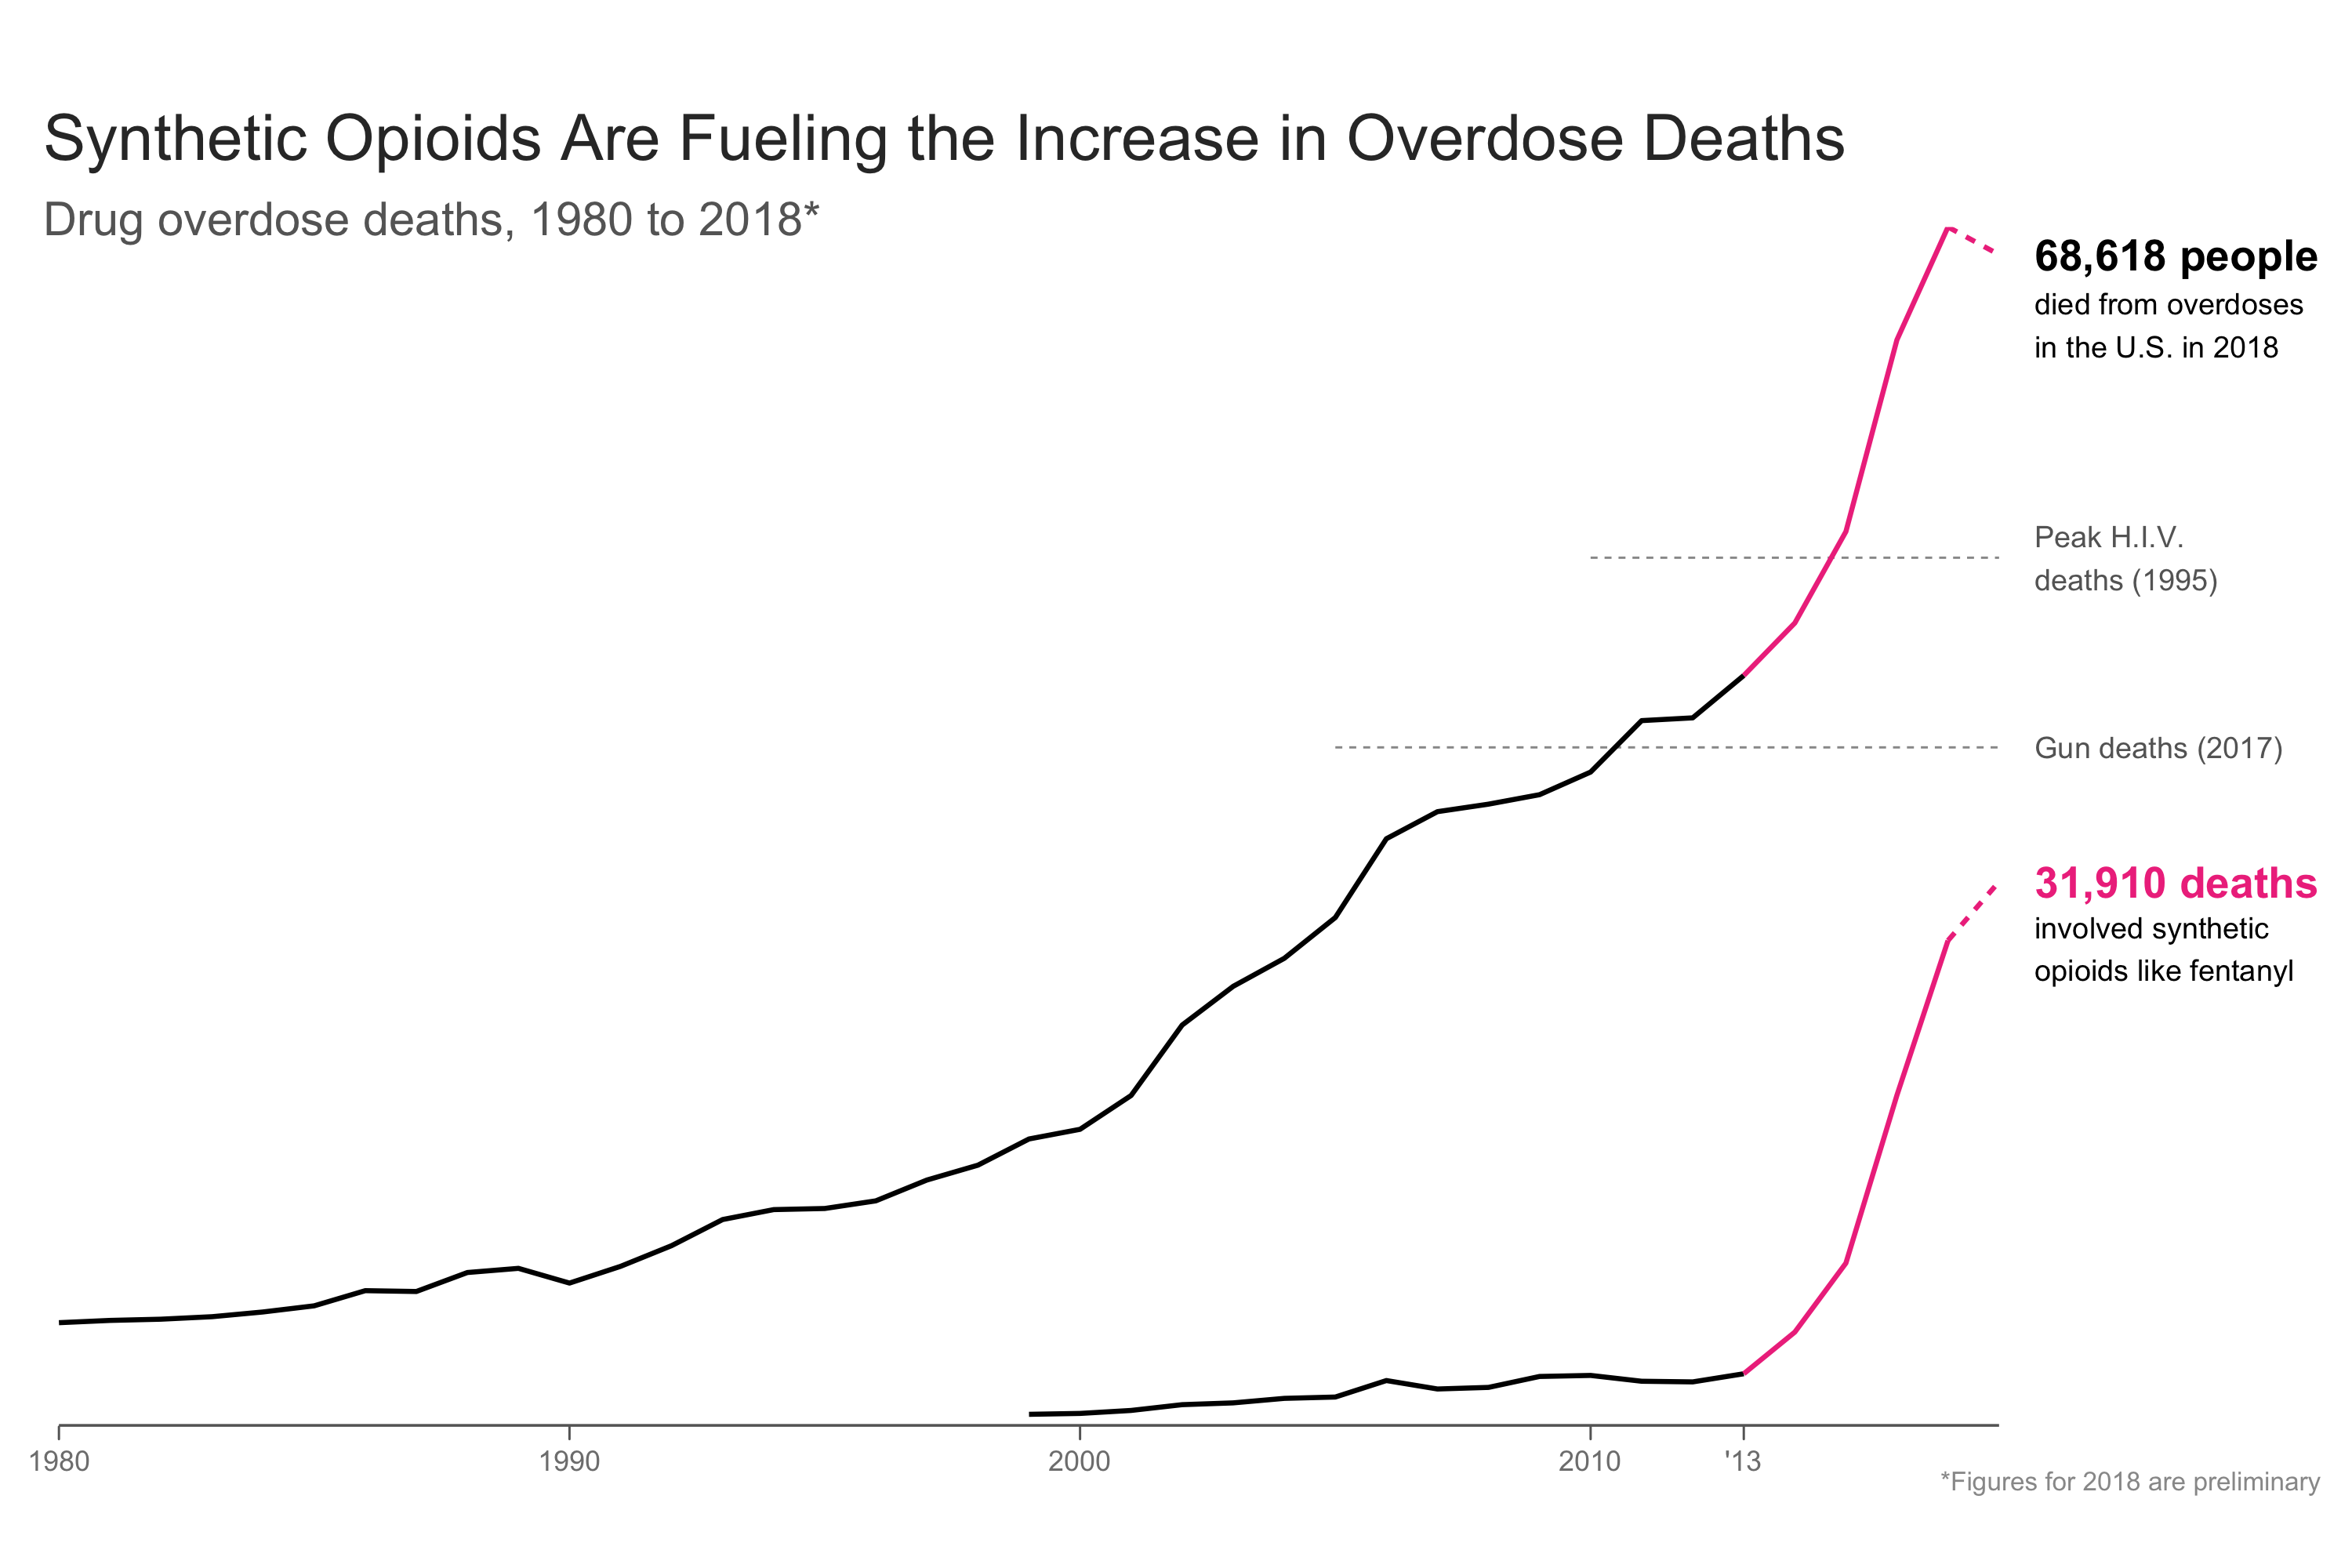

In [38]:
%%R -h 10 -w 15 -u in -r 200

# Save plot
q + ggsave('../output/fentanyl.png', device = 'png')